<a href="https://colab.research.google.com/github/Juliadambros/Sistema-de-Recomendacao-de-Filmes/blob/main/Recomenda%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Recomendação com SVD e NFM
Este notebook implementa um sistema de recomendação baseado em **filtragem colaborativa**, utilizando o algoritmo **SVD** e **NFM** da biblioteca `Surprise`

## Importação das Bibliotecas

In [ ]:
!pip install numpy==1.24.4
!pip uninstall -y scikit-surprise
!pip install scikit-surprise

from surprise import Dataset, Reader, SVD, NMF
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae, mse
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from surprise.model_selection import GridSearchCV

Found existing installation: scikit-surprise 1.1.4
Uninstalling scikit-surprise-1.1.4:
  Successfully uninstalled scikit-surprise-1.1.4
  Using cached scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl


##  Carregar o Dataset
O dataset deve conter pelo menos as colunas `userId`, `movieId` e `rating`.

In [ ]:
url = "http://files.grouplens.org/datasets/movielens/ml-100k/u.data"
df = pd.read_csv(url, sep='\t', names=['userId', 'itemId', 'rating', 'timestamp'])
df.head()

,userId,itemId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Carregando os dados dos filmes (para mostrar os nomes depois)

In [ ]:
movie_url = "http://files.grouplens.org/datasets/movielens/ml-100k/u.item"
movie_columns = ['itemId', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{i}' for i in range(19)]
movies_df = pd.read_csv(movie_url, sep='|', names=movie_columns, encoding='latin-1')

# Criando o dicionário de ID -> título do filme
movie_titles = dict(zip(movies_df['itemId'], movies_df['title']))

## Preparação dos Dados
Define o intervalo de notas e carrega os dados no formato da biblioteca `Surprise`.

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'itemId', 'rating']], reader)

## Divisão dos Dados
Dividimos em 80% para treino e 20% para teste.

In [ ]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=100)

### SVD padrão

## Treinamento do Modelo
Utilizamos o algoritmo **SVD**, que identifica padrões latentes nas avaliações.

In [ ]:
model = SVD()
model.fit(trainset)

## Avaliação do Modelo
Utilizamos RMSE e MAE como métricas de erro.

In [ ]:
predictions = model.test(testset)
print("Avaliação do Modelo SVD Padrão:")
svd_default_rmse = rmse(predictions)
svd_default_mse = mse(predictions)

# Cálculo do R² para SVD padrão
true_ratings = np.array([pred.r_ui for pred in predictions])
estimated_ratings = np.array([pred.est for pred in predictions])
mean_true = np.mean(true_ratings)
ss_res = np.sum((true_ratings - estimated_ratings) ** 2)
ss_tot = np.sum((true_ratings - mean_true) ** 2)
svd_default_r2 = 1 - (ss_res / ss_tot)
print("R²:", svd_default_r2)


Avaliação do Modelo SVD Padrão:
RMSE: 0.9345
MSE: 0.8732
R²: 0.30558193939061895


## Geração de Recomendações
Selecionamos um usuário e recomendamos filmes que ele ainda não avaliou, com base nas maiores notas previstas.

In [ ]:
user_id = 78
user_movies = df[df['userId'] == user_id]['itemId'].unique()
all_movie_ids = df['itemId'].unique()
movies_not_seen = [movie for movie in all_movie_ids if movie not in user_movies]

user_predictions = [model.predict(user_id, movie_id) for movie_id in movies_not_seen]
top_10 = sorted(user_predictions, key=lambda x: x.est, reverse=True)[:10]

## Exibir Títulos dos Filmes

In [ ]:
print(f"\nTop 10 recomendações para o usuário {user_id}:\n")
for pred in top_10:
    movie_name = movie_titles.get(int(pred.iid), f"ID {pred.iid}")
    print(f"{movie_name} — Nota prevista: {pred.est:.2f}")



Top 10 recomendações para o usuário 78:

Close Shave, A (1995) — Nota prevista: 4.69
Silence of the Lambs, The (1991) — Nota prevista: 4.54
L.A. Confidential (1997) — Nota prevista: 4.48
Godfather, The (1972) — Nota prevista: 4.47
Cinema Paradiso (1988) — Nota prevista: 4.46
Lawrence of Arabia (1962) — Nota prevista: 4.45
Casablanca (1942) — Nota prevista: 4.44
Hamlet (1996) — Nota prevista: 4.44
Usual Suspects, The (1995) — Nota prevista: 4.44
Shawshank Redemption, The (1994) — Nota prevista: 4.43


### Otimização com GridSearchCV no SVD

In [ ]:

param_grid = {
    'n_epochs': [500, 1000, 2000],
    'lr_all': [0.0001, 0.001, 0.005],
    'reg_all': [0.01, 0.1, 0.2]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mse'], cv=3, n_jobs=-1)
gs.fit(data)

print("\nMelhor RMSE encontrado:", gs.best_score['rmse'])
print("Melhores parâmetros para o SVD:", gs.best_params['rmse'])

# Treinamento do Modelo SVD com melhores hiperparâmetros

In [11]:
best_svd = SVD(**gs.best_params['rmse'])
best_svd.fit(trainset)

# Avaliação do SVD otimizado

In [12]:
best_predictions = best_svd.test(testset)

print("\nAvaliação do Melhor Modelo SVD (GridSearch):")
svd_grid_rmse = rmse(best_predictions)
svd_grid_mse = mse(best_predictions)
# Cálculo do R²
true_ratings = np.array([pred.r_ui for pred in best_predictions])
estimated_ratings = np.array([pred.est for pred in best_predictions])
mean_true = np.mean(true_ratings)

ss_res = np.sum((true_ratings - estimated_ratings) ** 2)
ss_tot = np.sum((true_ratings - mean_true) ** 2)

svd_grid_r2 = 1 - (ss_res / ss_tot)
print("R²:", svd_grid_r2)


Avaliação do Melhor Modelo SVD (GridSearch):
RMSE: 0.9069
MSE: 0.8225
R²: 0.34586971196506866


## Utilização do NFM (Fatoração de matriz não linear )

In [22]:
nmf_model = NMF()
nmf_model.fit(trainset)
nmf_predictions = nmf_model.test(testset)

print("\nAvaliação do Modelo NMF:")
nmf_rmse = rmse(nmf_predictions)
nmf_mse = mse(nmf_predictions)

# Cálculo do R² para NMF padrão
true_ratings = np.array([pred.r_ui for pred in nmf_predictions])
estimated_ratings = np.array([pred.est for pred in nmf_predictions])
mean_true = np.mean(true_ratings)
ss_res = np.sum((true_ratings - estimated_ratings) ** 2)
ss_tot = np.sum((true_ratings - mean_true) ** 2)
nmf_default_r2 = 1 - (ss_res / ss_tot)
print("R²:", nmf_default_r2)


Avaliação do Modelo NMF:
RMSE: 0.9628
MSE: 0.9270
R²: 0.2627885039092728


In [14]:
user_predictions_nmf = [nmf_model.predict(user_id, movie_id) for movie_id in movies_not_seen]
top_10_nmf = sorted(user_predictions_nmf, key=lambda x: x.est, reverse=True)[:10]

print(f"\nTop 10 recomendações para o usuário {user_id} com NMF:\n")
for pred in top_10_nmf:
    movie_name = movie_titles.get(int(pred.iid), f"ID {pred.iid}")
    print(f"{movie_name} — Nota prevista: {pred.est:.2f}")



Top 10 recomendações para o usuário 78 com NMF:

Chasing Amy (1997) — Nota prevista: 5.00
Inventing the Abbotts (1997) — Nota prevista: 5.00
Radioland Murders (1994) — Nota prevista: 5.00
Two Much (1996) — Nota prevista: 5.00
Panther (1995) — Nota prevista: 5.00
Innocents, The (1961) — Nota prevista: 5.00
World of Apu, The (Apur Sansar) (1959) — Nota prevista: 5.00
Stalker (1979) — Nota prevista: 5.00
Aparajito (1956) — Nota prevista: 5.00
Rendezvous in Paris (Rendez-vous de Paris, Les) (1995) — Nota prevista: 5.00


In [16]:
param_grid_nmf = {
    'n_factors': [ 50,100, 150],
    'n_epochs': [500, 1000, 2000],
    'reg_pu': [ 0.1, 0.15, 0.2],
    'reg_qi': [0.06, 0.1, 0.15]
}

gs_nmf = GridSearchCV(NMF, param_grid_nmf, measures=['rmse', 'mse'], cv=3, n_jobs=-1)
gs_nmf.fit(data)

print("\nMelhor RMSE encontrado para NMF:", gs_nmf.best_score['rmse'])
print("Melhores parâmetros para o NMF:", gs_nmf.best_params['rmse'])

best_nmf = NMF(**gs_nmf.best_params['rmse'])
best_nmf.fit(trainset)
best_nmf_predictions = best_nmf.test(testset)

nmf_grid_rmse = rmse(best_nmf_predictions)
nmf_grid_mse = mse(best_nmf_predictions)


Melhor RMSE encontrado para NMF: 0.9249361203205057
Melhores parâmetros para o NMF: {'n_factors': 150, 'n_epochs': 500, 'reg_pu': 0.2, 'reg_qi': 0.06}
RMSE: 0.9115
MSE: 0.8308
R²: 0.3393329689236054


In [18]:
# Cálculo do R²
true_ratings = np.array([pred.r_ui for pred in best_nmf_predictions])
estimated_ratings = np.array([pred.est for pred in best_nmf_predictions])
mean_true = np.mean(true_ratings)
ss_res = np.sum((true_ratings - estimated_ratings) ** 2)
ss_tot = np.sum((true_ratings - mean_true) ** 2)
nmf_grid_r2 = 1 - (ss_res / ss_tot)
print("R²:", nmf_grid_r2)

R²: 0.3393329689236054


### Comparação dos modelos em Gráfico

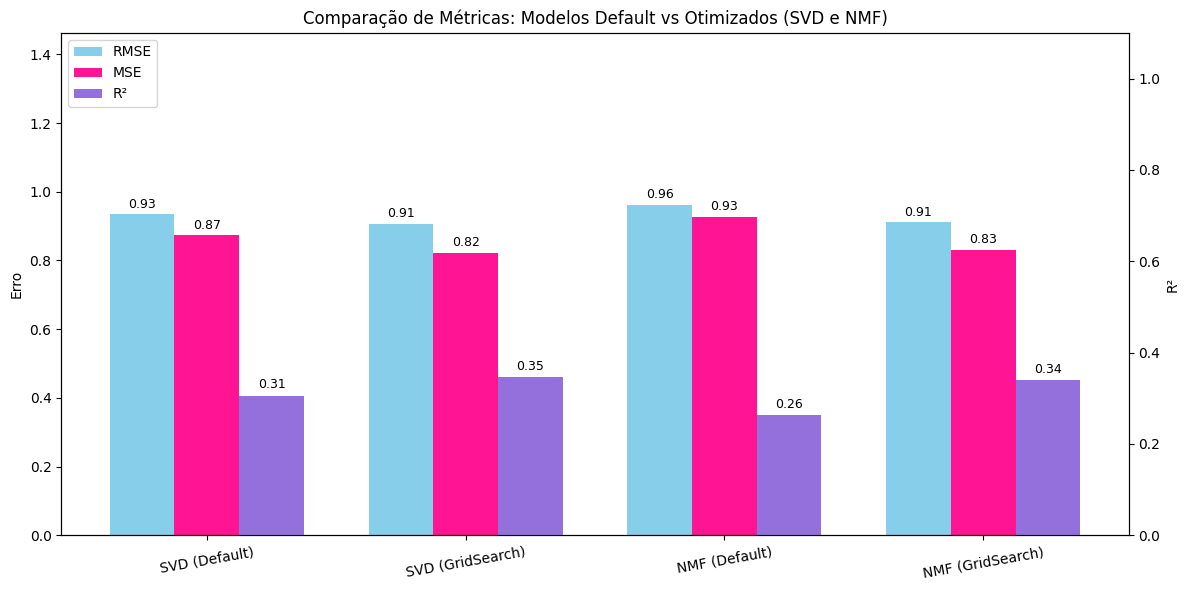

In [29]:
# Dados
models = ['SVD (Default)', 'SVD (GridSearch)', 'NMF (Default)', 'NMF (GridSearch)']
rmse_values = [svd_default_rmse, svd_grid_rmse, nmf_rmse, nmf_grid_rmse]
mse_values = [svd_default_mse, svd_grid_mse, nmf_mse, nmf_grid_mse]
r2_values = [svd_default_r2, svd_grid_r2, nmf_default_r2, nmf_grid_r2]

x = np.arange(len(models))
width = 0.25

fig, ax1 = plt.subplots(figsize=(12, 6))

# Eixo principal para RMSE e MSE
rects1 = ax1.bar(x - width, rmse_values, width, label='RMSE', color='skyblue')
rects2 = ax1.bar(x, mse_values, width, label='MSE', color='deeppink')
ax1.set_ylabel('Erro')
ax1.set_ylim(0, max(max(rmse_values), max(mse_values)) + 0.5)

# Eixo secundário para R²
ax2 = ax1.twinx()
rects3 = ax2.bar(x + width, r2_values, width, label='R²', color='mediumpurple')
ax2.set_ylabel('R²')
ax2.set_ylim(0, 1.1)  # R² geralmente entre 0 e 1

# Configurações do gráfico
ax1.set_title('Comparação de Métricas: Modelos Default vs Otimizados (SVD e NMF)')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=10)

# Adiciona legendas combinando dos dois eixos
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# Mostrar valores nas colunas
for i in range(len(models)):
    ax1.text(rects1[i].get_x() + rects1[i].get_width()/2., rects1[i].get_height() + 0.01,
             f'{rmse_values[i]:.2f}', ha='center', va='bottom', fontsize=9)
    ax1.text(rects2[i].get_x() + rects2[i].get_width()/2., rects2[i].get_height() + 0.01,
             f'{mse_values[i]:.2f}', ha='center', va='bottom', fontsize=9)
    ax2.text(rects3[i].get_x() + rects3[i].get_width()/2., rects3[i].get_height() + 0.01,
             f'{r2_values[i]:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
